In [1]:
#one hot encoding package
from sklearn.preprocessing import OneHotEncoder

#linear_model for logit regression from sklearn
from sklearn import linear_model

#numpy, pandas for data manipulation
import numpy as np
import pandas as pd

#MySQL connectivity
import mysql.connector as sql

#import sympy for formulaic expression of log-odds ratios, e.g., to produce % success rates from coefficients of logit reg
import sympy
from sympy.solvers import solve
from sympy import Symbol

# importing the requests library
import requests 
import json
import os

#yaml package for cred import
import yaml

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
#os.chdir("/db")
os.getcwd()

'C:\\Users\\goyetc\\mlb-machine-learning'

In [5]:
#Note: this is a pandas option to omit the warning that we are performing chained indexing. While one should be careful to avoid
#doing so when unintended (as can produce incorrect results), here we use this approach because .loc method seemed to cause errors in part of the script. If strange results are obtained at some point and no other cause can be identified, this should be revisited. 
#http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
pd.set_option('mode.chained_assignment', None)

In [6]:
#legacy pull from csv
df_csv = pd.read_csv("MLB_90d_raw.csv", encoding = "utf-8-sig").dropna(axis=0)
#df_csv.head()

In [7]:
df_csv.head()

,Unnamed: 0,row_names,des,tfs,tfs_zulu,date,end_speed,pitch_type,count,zone,pitcher,batter,p_throws,stand,inning_side,hitter_val,hv_binary,ptz
0,0,1,Ball,3852,2017-04-03T00:38:52Z,2017-04-02,86.1,FF,0-0,12,593372.0,656941.0,R,L,top,0.250000,0.0,FF_12
1,1,2,Foul,3906,2017-04-03T00:39:06Z,2017-04-02,87.7,SI,1-0,7,593372.0,656941.0,R,L,top,-0.333333,1.0,SI_7
2,2,3,Ball,3926,2017-04-03T00:39:26Z,2017-04-02,89.0,SI,1-1,13,593372.0,656941.0,R,L,top,0.250000,0.0,SI_13
3,3,4,"In play, no out",3943,2017-04-03T00:39:43Z,2017-04-02,77.9,SL,2-1,8,593372.0,656941.0,R,L,top,2.500000,0.0,SL_8
4,4,5,Called Strike,4031,2017-04-03T00:40:31Z,2017-04-02,89.5,SI,0-0,9,593372.0,592178.0,R,R,top,-0.333333,1.0,SI_9


In [8]:
df_csv.loc[df_csv.batter == 596059]

,Unnamed: 0,row_names,des,tfs,tfs_zulu,date,end_speed,pitch_type,count,zone,pitcher,batter,p_throws,stand,inning_side,hitter_val,hv_binary,ptz
1530,1530,619,Called Strike,234029,2017-04-03T23:40:29Z,2017-04-03,85.1,SI,0-0,4,446372.0,596059.0,R,L,bottom,-0.333333,1.0,SI_4
1531,1531,620,Called Strike,234047,2017-04-03T23:40:47Z,2017-04-03,84.2,SL,0-1,12,446372.0,596059.0,R,L,bottom,-0.333333,1.0,SL_12
1532,1532,621,Ball,234112,2017-04-03T23:41:12Z,2017-04-03,81.5,SL,0-2,11,446372.0,596059.0,R,L,bottom,0.250000,0.0,SL_11
1533,1533,622,Foul,234133,2017-04-03T23:41:33Z,2017-04-03,78.0,CU,1-2,6,446372.0,596059.0,R,L,bottom,-0.333333,1.0,CU_6
1534,1534,623,Ball,234203,2017-04-03T23:42:03Z,2017-04-03,84.8,SI,1-2,11,446372.0,596059.0,R,L,bottom,0.250000,0.0,SI_11
1535,1535,624,Ball,234223,2017-04-03T23:42:23Z,2017-04-03,85.3,FF,2-2,11,446372.0,596059.0,R,L,bottom,0.250000,0.0,FF_11
1536,1536,625,"In play, run(s)",234242,2017-04-03T23:42:42Z,2017-04-03,83.5,SI,3-2,2,446372.0,596059.0,R,L,bottom,4.500000,0.0,SI_2
1578,1578,667,"In play, run(s)",936,2017-04-04T00:09:36Z,2017-04-03,82.4,SI,0-0,4,446372.0,596059.0,R,L,bottom,3.000000,0.0,SI_4
1663,1663,752,Ball,10257,2017-04-04T01:02:57Z,2017-04-03,79.9,CU,0-0,11,446372.0,596059.0,R,L,bottom,0.250000,0.0,CU_11
1664,1664,753,Ball,10317,2017-04-04T01:03:17Z,2017-04-03,74.8,CH,1-0,11,446372.0,596059.0,R,L,bottom,0.250000,0.0,CH_11


In [9]:
df_csv['hv_binary'].loc[df_csv.batter == 502239].unique().size

2

In [10]:
#batter_count = df_csv[['batter','tfs','p_throws']].groupby(['batter','p_throws']).agg(['count'])
batter_count = df_csv.groupby(['batter','p_throws']).size().reset_index(name='counts')

In [12]:
batter_count.loc[batter_count.batter == 596059]

,batter,p_throws,counts
1117,596059.0,L,292
1118,596059.0,R,925


In [52]:
batter_count.sort_values(by=['counts'], ascending = True).head()

,batter,p_throws,counts
458,502004.0,L,1
893,572000.0,L,1
91,434628.0,L,1
941,573186.0,L,1
943,573244.0,R,1


In [15]:
batter_count.batter.unique().size

790

In [16]:
RHP_90d = batter_count.loc[batter_count['p_throws'] == 'R'].drop(columns=['p_throws'])
LHP_90d = batter_count.loc[batter_count['p_throws'] == 'L'].drop(columns=['p_throws'])

In [17]:
RHP_90d.shape, LHP_90d.shape

((769, 2), (670, 2))

In [19]:
print('{0:.0f}% of batters saw a RHP.'.format(100*769./790.)),
print('{0:.0f}% of batters saw a LHP.'.format(100*670./790.)),
print('{0:.0f}% of batters who saw a RHP, also saw a LHP in this time frame.'.format(100*670./769.))

97% of batters saw a RHP.
85% of batters saw a LHP.
87% of batters who saw a RHP, also saw a LHP in this time frame.


In [20]:
RHP_90d['counts'].describe(), LHP_90d['counts'].describe()

(count     769.000000
 mean      349.933680
 std       353.108775
 min         1.000000
 25%        29.000000
 50%       199.000000
 75%       662.000000
 max      1189.000000
 Name: counts, dtype: float64, count    670.000000
 mean     135.256716
 std      120.812545
 min        1.000000
 25%       22.000000
 50%      104.500000
 75%      233.750000
 max      531.000000
 Name: counts, dtype: float64)

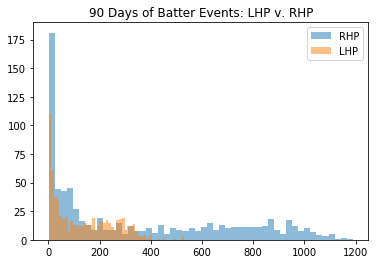

In [22]:
#fig, hist = plt.subplots(1, 2, sharex = True)
bins = 50
plt.hist(RHP_90d['counts'], bins, alpha = 0.5, label = 'RHP')
plt.hist(LHP_90d['counts'], bins, alpha = 0.5, label = 'LHP')
plt.legend(loc='upper right')
plt.title('90 Days of Batter Events: LHP v. RHP')
plt.show()

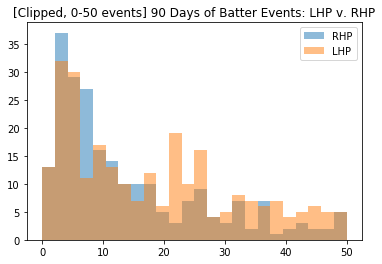

In [23]:
#fig, hist = plt.subplots(1, 2, sharex = True)
bins = np.linspace(0,50,25) 
plt.hist(RHP_90d['counts'], bins, alpha = 0.5, label = 'RHP')
plt.hist(LHP_90d['counts'], bins, alpha = 0.5, label = 'LHP')
plt.legend(loc='upper right')
plt.title('[Clipped, 0-50 events] 90 Days of Batter Events: LHP v. RHP')
plt.show()

#### Summary/Notes, raw data 
- Median # of pitches for batters against RHP in 90 days? 199
- Heavily skew right, aka high density at low event counts
- E.g., 25% is 29 events

##### LHP Notes
- Even more right skew.. note median event count of 104, max of 531 (vs 1189 v. RHP)

##### Thoughts for model
- consider "minimum" event count at 25%, e.g., 22 and 29. 
- this likely will not produce good results.. revisit

In [24]:
batters = df_csv['batter'].unique().tolist()

In [25]:
len(batters)

790

In [26]:
test = []
for i in batters[110:120]:
    test.append(i)
    print(i)

460576.0
425783.0
608577.0
435063.0
608070.0
543228.0
571980.0
596059.0
518960.0
608336.0


In [ ]:
596059

In [33]:
sample = np.random.choice(batters, 100)

In [30]:
len(sample)

50

In [53]:
def main():
    
    print("PREPARE TO MEET YOUR PITCHER'S FRIEND")
    print("...")
    print("..")
    print(".")
    print(" ")
    
    #open MySQL connection, pull data, close connection
    #db_con = sql.connect(host = mlb_host, database = mlb_db, user = mlb_db_user, password = mlb_db_pwd)
    #dataframe = pd.read_sql('SELECT pitcher, batter, p_throws, stand, hv_binary, ptz FROM rawdata_ML LIMIT 200000', con=db_con)
    #db_con.close()
    
    #clean data
    df = clean_data(df_csv)
    
    #define batters of interest by batter ID
    #batters_of_interest = [514888,453568,457759,519317,458015,547180,641355,592450,545361,457705,502671,518626,502517,518934,471865,592178,519346]
    batters_of_interest = batters
    #batters_of_interest = sample
    #batters_of_interest = [502239]
    
    #run model on var & batters of interest from current data
    return hv_model(['ptz','hv_binary'],batters_of_interest,df)

def clean_data(data):
    #clean data.. drop N/A, duplicate rows, observe shape
    data.dropna(axis=0)
    data=data.drop_duplicates()
    #df_input.shape
    
    #format pitcher, batter, hv_binary as int
    data[['pitcher','batter','hv_binary']] = data[['pitcher','batter','hv_binary']].astype(int)
    #df.dtypes
    
    return data

def hv_model(features,batters_list,data):
    #main modeling script.. needs to be broken up into smaller functions at some point in the future
    
    #empty dictionary for findings, count to track batter-specific model run #
    global findingsDict
    findingsDict = {}
    
    global analysisDict
    analysisDict = {}
    
    count = 0 
    
    #identify pitcher handedness. Like Jason has yet to see my ambidextrosity, we have yet to see anything more than "L" or "R", but we prefer this method to hard coding :P
    P_throws = data.p_throws.unique()

    #generate results for each batter in list
    for batter_id in batters_list:
        
        #per run (for each batter ID), produce two model results- against left handed pitchers and right handed pitchers
        #note these lists are cleared/recreated for *each* batter_id by nature of their creation within the for loop
        RHPfindingslist = list()
        LHPfindingslist = list()
        
        #status by model run/batter n of N batters, n:{1,N}
        print("")
        count += 1
        print("Run #:"+str(count))
        print("")
        #print('Batter ID:', batter_id)
        
        #Separating right handed pitcher results from LHP results
        for hand in P_throws:
            
            records = data[(data.batter == batter_id) & (data.p_throws == hand)]
            num_events = len(records.index)
            print("")
            print("Batter ID: %s" % (batter_id))
            print("Pitcher-handedness:", hand)
            print("number of events:", num_events)
            print("")
            
            records = records.sort_values(by=['tfs_zulu'], ascending = True)
            #print(records.hv_binary.unique().size)
            #print(records.head())
            
            #prevent batters with too few records from being used
            if num_events >= 50 and records.hv_binary.unique().size == 2:
    
                #select features to incorporate into model based on input argument
                var_interest = records[features]

                #ptz variable (pitch_zone combo) is categorical, prep for encoding
                if 'ptz' in var_interest:
                    var_interest.ptz = var_interest.ptz.astype(object)   
                else:
                    pass

                #label space Y: binary representation of hitter_val: if hv <0, 1; else, 0. 
                Y = var_interest[['hv_binary']]
                #print("Y.size:", Y.shape)

                #feature space X: drop labels in 'hv_binary'
                X = var_interest.drop(['hv_binary'], axis = 1)
                #print("X.size:", X.shape)

                #Create count_type var (ahead, behind, even) if including in model
                if 'count' in var_interest:
                    X['Balls'] = X['count'].apply(lambda x: x[:1])
                    X['Strikes'] = X['count'].apply(lambda x: x[-1:])

                    conditions = [(X['Balls'] > X['Strikes']), (X['Balls'] < X['Strikes'])]
                    choices = ['Behind', 'Ahead']
                    X['Count_type'] = np.select(conditions, choices, default='Even')

                    zone = X['zone'].to_frame()

                    #Drop unneeded columns
                    X = X.drop(['count','Balls','Strikes'], axis = 1)

                else:
                    pass

                #Create one_hot encoded predictor array for logistic regression
                X_hot = pd.get_dummies(X)
                #print("X_hot.size:", X_hot.shape)
                
                #create train/test splits
                #X_train, X_val, y_train, y_val = train_test_split(X_hot, Y, test_size=0.25, random_state=42)

                #create time-dependent splits for train and validation
                t_s = int(0.8 * num_events)
                X_train = X_hot[:t_s]
                X_val = X_hot[t_s:]
                y_train = Y[:t_s]
                y_val = Y[t_s:]
                
                #Logistic regression model, initialize function from sklearn
                logit_reg = linear_model.LogisticRegression(random_state = 42)

                #linear regression on one-hot encoded data X and Y HVAL labels
                model = logit_reg.fit(X_train, y_train.values.ravel())

                #Average success, from pitcher's perspective.  Note that this is just the baseline likelihood of predicting the correct outcome by chance. We compare our model accuracy to this value.
                avg_success=y_train.mean().values[0]

                #Baseline pitcher success rate
                #print("Random %s-handed pitcher's baseline success ratio against hitter:" % (hand, , Y.mean())
                if hand == 'R':
                        RHPfindingslist.append(("Based on the last 90 days' worth of pitches against this batter, %s-handed pitchers have a %s success rate." % (hand,"{0:.0f}%".format(avg_success* 100))))
                elif hand == 'L':
                        LHPfindingslist.append(("Based on the last 90 days' worth of pitches against this batter, %s-handed pitchers have a %s success rate." % (hand,"{0:.0f}%".format(avg_success* 100))))
                else:
                    pass

                #logistic regression results
                Results = pd.DataFrame(list(zip(X_hot.columns, np.transpose(model.coef_), np.transpose(np.exp(model.coef_)), abs(np.transpose(np.exp(model.coef_)-1)))))
                Results.columns = ['Recommendation', 'LR_coeff/Log_Odds', 'Odds_Ratio', 'Abs_Odds_Ratio_-1']

                #sorted results
                Results = Results.sort_values(by='Abs_Odds_Ratio_-1', ascending = False)
                Top_5 = Results[['Recommendation','Odds_Ratio']][:5]
                Top_5.Odds_Ratio = Top_5.Odds_Ratio.astype(float)


                #Use sympy to translate logistic regression coefficients into odds ratio, e.g., improved odds of success of choosing this feature
                x = Symbol('x')

                for index,row in Top_5.iterrows():

                    #log-odds ratio calc
                    Top_5.loc[index,'New_Odds'] = solve(Top_5.loc[index,'Odds_Ratio']-((x/(1-x))/(Y.mean()/(1-Y.mean()))), x)

                #string formatting
                Top_5['New_Odds']= Top_5['New_Odds'].str.get(0)
                #print(Top_5['New_Odds'], Top_5['Odds_Ratio'])

                #Creating new series pt:pitch_type and zc:zone_catcher, e.g., zone from catcher's perspective
                #Credit to Benita!
                s= Top_5['Recommendation'].apply(lambda x: x.split('_'))
                Top_5['pt'] = s.apply(lambda x: x[1])
                Top_5['zc'] = s.apply(lambda x: x[2])

                #Translation of codes to descriptive terms: pitch type
                def applyFunc(s):
                    if s == 'FF':
                        return 'four-seam fastball'
                    elif s == 'SI':
                        return 'sinker'
                    elif s == 'SL':
                        return 'slider'
                    elif s == 'KN':
                        return 'knuckleball'
                    elif s == 'CH':
                        return 'change-up'
                    elif s == 'CU':
                        return 'curve-ball'
                    elif s == 'FT':
                        return 'two-seam fastball'
                    return ''

                #create series of descriptive pitch type: zones
                Top_5['pitch_descrip'] = Top_5['pt'].apply(applyFunc)

                def applyFunc2(s):
                    if s == '1':
                        return 'to the top right'
                    elif s == '2':
                        return 'top center'
                    elif s == '3':
                        return 'to the top left'
                    elif s == '4':
                        return 'center right'
                    elif s == '5':
                        return 'down the middle'
                    elif s == '6':
                        return 'center left'
                    elif s == '7':
                        return 'to the bottom right'
                    elif s == '8':
                        return 'bottom center'
                    elif s == '9':
                        return 'to the bottom left'
                    elif s == '10':
                        return 'into outer space'
                    elif s == '11':
                        return 'upper right of strike zone'
                    elif s == '12':
                        return 'upper left of strike zone'
                    elif s == '13':
                        return 'bottom right of strike zone'
                    elif s == '14':
                        return 'bottom left of strike zone'
                    return ''

                #create series to describe zones, mirroring to be seen from pitcher's perspective
                Top_5['zone_descrip'] = Top_5['zc'].apply(applyFunc2)    

                #Print the results!
                print("Based on the last 90 days' worth of pitches against this batter, %s-handed pitchers have a %s success rate." % (hand,"{0:.0f}%".format(avg_success* 100)))
                print("")
                
                model_score = model.score(X_val, y_val)

                for index,row in Top_5.iterrows():
                    print("Throw a %s %s for a success rate of %s." % (Top_5.loc[index,'pitch_descrip'], Top_5.loc[index, 'zone_descrip'], "{0:.0f}%".format(Top_5.loc[index,'New_Odds'] * 100)))

                    if hand == 'R':
                        RHPfindingslist.append("Throw a %s %s for a success rate of %s." % (Top_5.loc[index,'pitch_descrip'], Top_5.loc[index, 'zone_descrip'], "{0:.0f}%".format(Top_5.loc[index,'New_Odds'] * 100)))
                        
                    elif hand == 'L':
                        LHPfindingslist.append("Throw a %s %s for a success rate of %s." % (Top_5.loc[index,'pitch_descrip'], Top_5.loc[index, 'zone_descrip'], "{0:.0f}%".format(Top_5.loc[index,'New_Odds'] * 100)))
                        
                    else:
                        pass

                print("")
                print("Note: Model Accuracy, based on %s pitches:" % num_events, "{0:.0%}".format(model_score))
                print("")
        
                try:
                    if hand == 'R':
                        analysisDict[batter_id] = {'num_events-R': num_events, 'model_score-R': model_score}
                    else:
                        analysisDict[batter_id].update({'num_events-L': num_events, 'model_score-L': model_score})
                except:
                    pass
        
            else:
                print("Not enough pitches made to this batter by {}-handed pitchers, or all events have same outcome".format(hand))
                continue
           
        print("")
        print("HOORAY!")
        print("")

        #Note- this is dictionary containing findings results per pitcher. 
        findingsDict[batter_id] = {'left_hand_pitcher_findings': LHPfindingslist, 'right_hand_pitcher_findings': RHPfindingslist}

        # api-endpoint
        #URL = 'http://mlb-player-api.cfapps.io/player/%d/insight' % (batter_id)
        #URL = 'http://mlb-api.cfapps.io/player/%d/insight' % (batter_id)
        #try:
        #    r = requests.post(url = URL, json = findingsDict[batter_id])
        #    print("HTTP status code: "+str(r.status_code))
        #    r.raise_for_status()
        #except requests.exceptions.HTTPError as err:
        #    print(err)
        
    return("")


In [54]:
if __name__ == "__main__":   
    
    main()

PREPARE TO MEET YOUR PITCHER'S FRIEND
...
..
.
 

Run #:1


Batter ID: 656941.0
Pitcher-handedness: R
number of events: 869

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 55% success rate.

Throw a four-seam fastball down the middle for a success rate of 86%.
Throw a four-seam fastball center left for a success rate of 84%.
Throw a sinker to the bottom right for a success rate of 81%.
Throw a sinker center right for a success rate of 79%.
Throw a four-seam fastball top center for a success rate of 77%.

Note: Model Accuracy, based on 869 pitches: 67%


Batter ID: 656941.0
Pitcher-handedness: L
number of events: 286

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 55% success rate.

Throw a four-seam fastball center right for a success rate of 78%.
Throw a four-seam fastball bottom center for a success rate of 76%.
Throw a four-seam fastball top center for a success rate of 76%.
Throw a four-seam fastb

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 64% success rate.

Throw a slider down the middle for a success rate of 74%.
Throw a four-seam fastball bottom center for a success rate of 74%.
Throw a curve-ball bottom right of strike zone for a success rate of 28%.
Throw a slider upper right of strike zone for a success rate of 32%.
Throw a four-seam fastball center left for a success rate of 71%.

Note: Model Accuracy, based on 88 pitches: 44%


HOORAY!


Run #:9


Batter ID: 608365.0
Pitcher-handedness: R
number of events: 740

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 58% success rate.

Throw a four-seam fastball center left for a success rate of 84%.
Throw a four-seam fastball to the bottom left for a success rate of 83%.
Throw a four-seam fastball to the top right for a success rate of 83%.
Throw a four-seam fastball to the top left for a success rate of 80%.
Throw a sinker to the bottom lef

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 67% success rate.

Throw a slider center left for a success rate of 82%.
Throw a sinker to the bottom right for a success rate of 80%.
Throw a four-seam fastball center left for a success rate of 80%.
Throw a four-seam fastball upper left of strike zone for a success rate of 37%.
Throw a four-seam fastball to the bottom right for a success rate of 77%.

Note: Model Accuracy, based on 80 pitches: 69%


Batter ID: 593372.0
Pitcher-handedness: L
number of events: 23

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:17


Batter ID: 452657.0
Pitcher-handedness: R
number of events: 92

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 59% success rate.

Throw a four-seam fastball down the middle for a success rate of 81%.
Throw a four-seam fastball to the top right for a success rate of 77%.
Throw a four

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 55% success rate.

Throw a sinker center right for a success rate of 76%.
Throw a four-seam fastball to the top right for a success rate of 76%.
Throw a four-seam fastball center right for a success rate of 74%.
Throw a four-seam fastball to the top left for a success rate of 74%.
Throw a slider to the bottom right for a success rate of 74%.

Note: Model Accuracy, based on 285 pitches: 72%


HOORAY!


Run #:25


Batter ID: 596142.0
Pitcher-handedness: R
number of events: 680

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 55% success rate.

Throw a slider bottom center for a success rate of 82%.
Throw a four-seam fastball to the bottom left for a success rate of 77%.
Throw a four-seam fastball center left for a success rate of 76%.
Throw a sinker to the top right for a success rate of 75%.
Throw a four-seam fastball to the bottom right for a success rate 

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 51% success rate.

Throw a four-seam fastball to the bottom left for a success rate of 78%.
Throw a sinker center right for a success rate of 75%.
Throw a four-seam fastball down the middle for a success rate of 73%.
Throw a slider down the middle for a success rate of 73%.
Throw a four-seam fastball center left for a success rate of 73%.

Note: Model Accuracy, based on 383 pitches: 69%


HOORAY!


Run #:33


Batter ID: 489149.0
Pitcher-handedness: R
number of events: 937

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 53% success rate.

Throw a four-seam fastball to the top right for a success rate of 84%.
Throw a four-seam fastball down the middle for a success rate of 81%.
Throw a four-seam fastball top center for a success rate of 78%.
Throw a sinker bottom center for a success rate of 78%.
Throw a curve-ball bottom center for a success rate of 78%.



Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 60% success rate.

Throw a sinker center left for a success rate of 83%.
Throw a four-seam fastball to the top left for a success rate of 83%.
Throw a sinker to the top right for a success rate of 76%.
Throw a change-up to the bottom left for a success rate of 76%.
Throw a four-seam fastball to the bottom right for a success rate of 76%.

Note: Model Accuracy, based on 433 pitches: 61%


Batter ID: 591720.0
Pitcher-handedness: L
number of events: 75

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 55% success rate.

Throw a sinker to the top left for a success rate of 65%.
Throw a slider bottom right of strike zone for a success rate of 65%.
Throw a four-seam fastball down the middle for a success rate of 65%.
Throw a sinker upper left of strike zone for a success rate of 65%.
Throw a curve-ball bottom left of strike zone for a success rate of 33%.

Note: 

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 47% success rate.

Throw a sinker top center for a success rate of 69%.
Throw a four-seam fastball top center for a success rate of 69%.
Throw a sinker bottom center for a success rate of 69%.
Throw a four-seam fastball center right for a success rate of 69%.
Throw a sinker center left for a success rate of 69%.

Note: Model Accuracy, based on 309 pitches: 66%


HOORAY!


Run #:48


Batter ID: 543063.0
Pitcher-handedness: R
number of events: 738

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 56% success rate.

Throw a four-seam fastball top center for a success rate of 84%.
Throw a four-seam fastball to the top left for a success rate of 83%.
Throw a change-up bottom center for a success rate of 83%.
Throw a slider to the bottom right for a success rate of 82%.
Throw a slider down the middle for a success rate of 75%.

Note: Model Accuracy, based on 738 

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 49% success rate.

Throw a sinker center left for a success rate of 78%.
Throw a four-seam fastball center right for a success rate of 77%.
Throw a four-seam fastball to the bottom right for a success rate of 75%.
Throw a slider center right for a success rate of 73%.
Throw a change-up bottom center for a success rate of 73%.

Note: Model Accuracy, based on 1060 pitches: 73%


Batter ID: 571875.0
Pitcher-handedness: L
number of events: 284

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 61% success rate.

Throw a four-seam fastball center right for a success rate of 83%.
Throw a four-seam fastball bottom center for a success rate of 81%.
Throw a slider to the bottom right for a success rate of 80%.
Throw a four-seam fastball top center for a success rate of 76%.
Throw a sinker down the middle for a success rate of 76%.

Note: Model Accuracy, based on 284 

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 56% success rate.

Throw a four-seam fastball center left for a success rate of 81%.
Throw a sinker center left for a success rate of 80%.
Throw a slider to the bottom left for a success rate of 75%.
Throw a four-seam fastball bottom center for a success rate of 75%.
Throw a slider center left for a success rate of 73%.

Note: Model Accuracy, based on 421 pitches: 78%


Batter ID: 455104.0
Pitcher-handedness: L
number of events: 122

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 54% success rate.

Throw a sinker bottom center for a success rate of 71%.
Throw a sinker upper left of strike zone for a success rate of 71%.
Throw a four-seam fastball center left for a success rate of 71%.
Throw a four-seam fastball down the middle for a success rate of 67%.
Throw a change-up down the middle for a success rate of 67%.

Note: Model Accuracy, based on 122 pitche

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 52% success rate.

Throw a four-seam fastball center right for a success rate of 84%.
Throw a four-seam fastball to the top right for a success rate of 82%.
Throw a change-up bottom center for a success rate of 78%.
Throw a slider bottom center for a success rate of 77%.
Throw a curve-ball to the top right for a success rate of 76%.

Note: Model Accuracy, based on 1070 pitches: 75%


Batter ID: 459964.0
Pitcher-handedness: L
number of events: 95

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 58% success rate.

Throw a sinker bottom center for a success rate of 81%.
Throw a four-seam fastball to the top right for a success rate of 76%.
Throw a four-seam fastball upper right of strike zone for a success rate of 74%.
Throw a curve-ball bottom right of strike zone for a success rate of 28%.
Throw a four-seam fastball bottom center for a success rate of 73%.


Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 64% success rate.

Throw a sinker upper left of strike zone for a success rate of 76%.
Throw a four-seam fastball to the top right for a success rate of 76%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 34%.
Throw a slider center right for a success rate of 73%.
Throw a slider bottom center for a success rate of 73%.

Note: Model Accuracy, based on 73 pitches: 67%


HOORAY!


Run #:80


Batter ID: 476704.0
Pitcher-handedness: R
number of events: 1017

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 54% success rate.

Throw a four-seam fastball down the middle for a success rate of 85%.
Throw a sinker center left for a success rate of 82%.
Throw a four-seam fastball center right for a success rate of 81%.
Throw a four-seam fastball bottom center for a success rate of 79%.
Throw a four-seam fastball to the bottom left for a su

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 57% success rate.

Throw a slider bottom center for a success rate of 84%.
Throw a four-seam fastball to the top left for a success rate of 84%.
Throw a slider to the top left for a success rate of 81%.
Throw a four-seam fastball down the middle for a success rate of 79%.
Throw a four-seam fastball center left for a success rate of 79%.

Note: Model Accuracy, based on 1015 pitches: 62%


Batter ID: 621020.0
Pitcher-handedness: L
number of events: 169

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 49% success rate.

Throw a sinker down the middle for a success rate of 79%.
Throw a four-seam fastball to the bottom left for a success rate of 71%.
Throw a four-seam fastball to the top left for a success rate of 67%.
Throw a four-seam fastball center left for a success rate of 67%.
Throw a slider bottom center for a success rate of 67%.

Note: Model Accuracy,

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 59% success rate.

Throw a sinker center right for a success rate of 79%.
Throw a sinker center left for a success rate of 79%.
Throw a sinker bottom center for a success rate of 79%.
Throw a sinker to the top right for a success rate of 74%.
Throw a sinker to the bottom right for a success rate of 74%.

Note: Model Accuracy, based on 236 pitches: 62%


HOORAY!


Run #:95


Batter ID: 408252.0
Pitcher-handedness: R
number of events: 875

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 58% success rate.

Throw a four-seam fastball to the top left for a success rate of 80%.
Throw a slider down the middle for a success rate of 78%.
Throw a sinker bottom center for a success rate of 78%.
Throw a four-seam fastball down the middle for a success rate of 78%.
Throw a four-seam fastball to the bottom left for a success rate of 76%.

Note: Model Accuracy, based on 


Batter ID: 527054.0
Pitcher-handedness: L
number of events: 30

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:103


Batter ID: 592789.0
Pitcher-handedness: R
number of events: 41

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 592789.0
Pitcher-handedness: L
number of events: 6

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:104


Batter ID: 527038.0
Pitcher-handedness: R
number of events: 568

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 57% success rate.

Throw a four-seam fastball down the middle for a success rate of 85%.
Throw a four-seam fastball to the top left for a success rate of 81%.
Throw a sinker top center for a success rate of 76%.
Throw a slider center right for a success rate of 76%.
Throw a curve-ball upper left of strike zone for a success r

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 62% success rate.

Throw a curve-ball bottom right of strike zone for a success rate of 81%.
Throw a sinker to the top left for a success rate of 78%.
Throw a four-seam fastball bottom center for a success rate of 75%.
Throw a four-seam fastball center left for a success rate of 75%.
Throw a four-seam fastball down the middle for a success rate of 75%.

Note: Model Accuracy, based on 176 pitches: 81%


HOORAY!


Run #:112


Batter ID: 425783.0
Pitcher-handedness: R
number of events: 986

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 52% success rate.

Throw a four-seam fastball to the bottom left for a success rate of 82%.
Throw a change-up down the middle for a success rate of 77%.
Throw a sinker center right for a success rate of 75%.
Throw a slider to the bottom left for a success rate of 75%.
Throw a sinker center left for a success rate of 75%.

Not

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 55% success rate.

Throw a four-seam fastball down the middle for a success rate of 80%.
Throw a sinker center left for a success rate of 76%.
Throw a sinker down the middle for a success rate of 76%.
Throw a four-seam fastball center right for a success rate of 76%.
Throw a four-seam fastball bottom center for a success rate of 76%.

Note: Model Accuracy, based on 193 pitches: 67%


HOORAY!


Run #:120


Batter ID: 608336.0
Pitcher-handedness: R
number of events: 914

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 54% success rate.

Throw a change-up to the bottom right for a success rate of 84%.
Throw a four-seam fastball center right for a success rate of 81%.
Throw a four-seam fastball bottom center for a success rate of 81%.
Throw a four-seam fastball to the bottom right for a success rate of 78%.
Throw a sinker center right for a success rate of 76%

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 60% success rate.

Throw a four-seam fastball top center for a success rate of 83%.
Throw a slider to the bottom right for a success rate of 78%.
Throw a sinker to the top left for a success rate of 76%.
Throw a four-seam fastball upper right of strike zone for a success rate of 27%.
Throw a slider to the bottom left for a success rate of 73%.

Note: Model Accuracy, based on 243 pitches: 65%


HOORAY!


Run #:128


Batter ID: 542340.0
Pitcher-handedness: R
number of events: 763

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 56% success rate.

Throw a four-seam fastball center right for a success rate of 85%.
Throw a four-seam fastball to the top left for a success rate of 84%.
Throw a sinker to the bottom right for a success rate of 82%.
Throw a slider to the bottom left for a success rate of 79%.
Throw a four-seam fastball to the top right for a success

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 53% success rate.

Throw a sinker to the bottom right for a success rate of 80%.
Throw a four-seam fastball to the top right for a success rate of 77%.
Throw a slider center right for a success rate of 76%.
Throw a sinker down the middle for a success rate of 76%.
Throw a slider top center for a success rate of 76%.

Note: Model Accuracy, based on 569 pitches: 63%


Batter ID: 547172.0
Pitcher-handedness: L
number of events: 139

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 56% success rate.

Throw a slider bottom center for a success rate of 75%.
Throw a four-seam fastball to the bottom right for a success rate of 72%.
Throw a slider down the middle for a success rate of 72%.
Throw a four-seam fastball center right for a success rate of 72%.
Throw a four-seam fastball to the top right for a success rate of 70%.

Note: Model Accuracy, based on 139 pitch

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 61% success rate.

Throw a slider down the middle for a success rate of 73%.
Throw a change-up bottom right of strike zone for a success rate of 73%.
Throw a sinker upper right of strike zone for a success rate of 24%.
Throw a change-up upper right of strike zone for a success rate of 27%.
Throw a curve-ball bottom right of strike zone for a success rate of 33%.

Note: Model Accuracy, based on 129 pitches: 62%


Batter ID: 543590.0
Pitcher-handedness: L
number of events: 6

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:145


Batter ID: 506924.0
Pitcher-handedness: R
number of events: 43

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 506924.0
Pitcher-handedness: L
number of events: 84

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 63%

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 51% success rate.

Throw a four-seam fastball to the top left for a success rate of 75%.
Throw a change-up center left for a success rate of 75%.
Throw a four-seam fastball to the top right for a success rate of 72%.
Throw a sinker to the top left for a success rate of 70%.
Throw a four-seam fastball top center for a success rate of 68%.

Note: Model Accuracy, based on 295 pitches: 63%


HOORAY!


Run #:153


Batter ID: 543257.0
Pitcher-handedness: R
number of events: 680

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 52% success rate.

Throw a four-seam fastball to the bottom right for a success rate of 82%.
Throw a four-seam fastball bottom center for a success rate of 77%.
Throw a four-seam fastball down the middle for a success rate of 76%.
Throw a four-seam fastball to the top right for a success rate of 76%.
Throw a curve-ball down the middle for a

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 52% success rate.

Throw a four-seam fastball down the middle for a success rate of 79%.
Throw a sinker down the middle for a success rate of 77%.
Throw a four-seam fastball to the top left for a success rate of 75%.
Throw a four-seam fastball center right for a success rate of 72%.
Throw a four-seam fastball to the bottom right for a success rate of 70%.

Note: Model Accuracy, based on 236 pitches: 79%


HOORAY!


Run #:161


Batter ID: 593871.0
Pitcher-handedness: R
number of events: 737

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 56% success rate.

Throw a four-seam fastball to the top right for a success rate of 86%.
Throw a four-seam fastball bottom center for a success rate of 85%.
Throw a four-seam fastball down the middle for a success rate of 84%.
Throw a four-seam fastball center right for a success rate of 81%.
Throw a sinker center left fo

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 52% success rate.

Throw a four-seam fastball to the top right for a success rate of 75%.
Throw a four-seam fastball center left for a success rate of 75%.
Throw a curve-ball center left for a success rate of 75%.
Throw a sinker to the bottom left for a success rate of 72%.
Throw a sinker center left for a success rate of 72%.

Note: Model Accuracy, based on 357 pitches: 65%


HOORAY!


Run #:169


Batter ID: 607208.0
Pitcher-handedness: R
number of events: 966

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 54% success rate.

Throw a slider to the bottom left for a success rate of 81%.
Throw a four-seam fastball to the bottom right for a success rate of 80%.
Throw a slider to the bottom right for a success rate of 76%.
Throw a slider center right for a success rate of 76%.
Throw a curve-ball to the bottom left for a success rate of 73%.

Note: Model Accu

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 54% success rate.

Throw a four-seam fastball top center for a success rate of 80%.
Throw a sinker center left for a success rate of 76%.
Throw a sinker to the bottom right for a success rate of 74%.
Throw a curve-ball to the bottom left for a success rate of 74%.
Throw a sinker to the bottom left for a success rate of 74%.

Note: Model Accuracy, based on 982 pitches: 69%


Batter ID: 542303.0
Pitcher-handedness: L
number of events: 254

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 51% success rate.

Throw a four-seam fastball to the bottom right for a success rate of 75%.
Throw a four-seam fastball top center for a success rate of 72%.
Throw a change-up to the bottom left for a success rate of 72%.
Throw a four-seam fastball center right for a success rate of 72%.
Throw a sinker center left for a success rate of 71%.

Note: Model Accuracy, based on 254

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 53% success rate.

Throw a four-seam fastball center right for a success rate of 78%.
Throw a four-seam fastball down the middle for a success rate of 78%.
Throw a curve-ball to the top left for a success rate of 76%.
Throw a curve-ball to the bottom right for a success rate of 76%.
Throw a curve-ball center right for a success rate of 76%.

Note: Model Accuracy, based on 732 pitches: 61%


Batter ID: 514917.0
Pitcher-handedness: L
number of events: 288

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 57% success rate.

Throw a four-seam fastball center left for a success rate of 81%.
Throw a sinker to the top left for a success rate of 78%.
Throw a sinker center left for a success rate of 76%.
Throw a four-seam fastball top center for a success rate of 74%.
Throw a sinker center right for a success rate of 72%.

Note: Model Accuracy, based on 288 pitches:

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 62% success rate.

Throw a four-seam fastball down the middle for a success rate of 80%.
Throw a sinker center left for a success rate of 78%.
Throw a slider center left for a success rate of 78%.
Throw a four-seam fastball center left for a success rate of 76%.
Throw a sinker to the bottom left for a success rate of 76%.

Note: Model Accuracy, based on 255 pitches: 69%


HOORAY!


Run #:194


Batter ID: 458015.0
Pitcher-handedness: R
number of events: 964

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 48% success rate.

Throw a four-seam fastball to the top right for a success rate of 80%.
Throw a four-seam fastball to the bottom right for a success rate of 76%.
Throw a change-up to the bottom right for a success rate of 75%.
Throw a sinker top center for a success rate of 75%.
Throw a sinker center left for a success rate of 75%.

Note: Model Accuracy,

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 54% success rate.

Throw a change-up to the bottom left for a success rate of 71%.
Throw a sinker to the bottom left for a success rate of 69%.
Throw a slider top center for a success rate of 69%.
Throw a four-seam fastball to the top left for a success rate of 69%.
Throw a change-up bottom center for a success rate of 69%.

Note: Model Accuracy, based on 252 pitches: 65%


HOORAY!


Run #:202


Batter ID: 571466.0
Pitcher-handedness: R
number of events: 554

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 55% success rate.

Throw a four-seam fastball bottom center for a success rate of 78%.
Throw a sinker center left for a success rate of 78%.
Throw a four-seam fastball top center for a success rate of 77%.
Throw a sinker top center for a success rate of 77%.
Throw a sinker center right for a success rate of 74%.

Note: Model Accuracy, based on 554 pitche

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 53% success rate.

Throw a four-seam fastball down the middle for a success rate of 73%.
Throw a four-seam fastball center right for a success rate of 73%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 14%.
Throw a slider to the top right for a success rate of 66%.
Throw a four-seam fastball center left for a success rate of 66%.

Note: Model Accuracy, based on 157 pitches: 69%


HOORAY!


Run #:210


Batter ID: 605137.0
Pitcher-handedness: R
number of events: 990

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 53% success rate.

Throw a sinker to the bottom right for a success rate of 86%.
Throw a four-seam fastball to the bottom right for a success rate of 78%.
Throw a sinker bottom center for a success rate of 78%.
Throw a change-up bottom center for a success rate of 76%.
Throw a sinker center right for a success rate of

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 58% success rate.

Throw a four-seam fastball top center for a success rate of 80%.
Throw a slider down the middle for a success rate of 78%.
Throw a slider to the bottom right for a success rate of 72%.
Throw a change-up center left for a success rate of 72%.
Throw a sinker down the middle for a success rate of 72%.

Note: Model Accuracy, based on 156 pitches: 69%


Batter ID: 516782.0
Pitcher-handedness: L
number of events: 74

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 63% success rate.

Throw a four-seam fastball top center for a success rate of 80%.
Throw a change-up to the bottom left for a success rate of 80%.
Throw a four-seam fastball down the middle for a success rate of 80%.
Throw a four-seam fastball to the bottom left for a success rate of 75%.
Throw a four-seam fastball center left for a success rate of 75%.

Note: Model Accuracy, based 

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 54% success rate.

Throw a sinker to the bottom left for a success rate of 73%.
Throw a change-up to the top left for a success rate of 70%.
Throw a slider to the bottom right for a success rate of 70%.
Throw a four-seam fastball to the bottom right for a success rate of 70%.
Throw a change-up bottom center for a success rate of 70%.

Note: Model Accuracy, based on 263 pitches: 64%


HOORAY!


Run #:225


Batter ID: 622534.0
Pitcher-handedness: R
number of events: 586

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 59% success rate.

Throw a four-seam fastball center left for a success rate of 86%.
Throw a slider center left for a success rate of 82%.
Throw a sinker to the top left for a success rate of 79%.
Throw a slider center right for a success rate of 77%.
Throw a sinker top center for a success rate of 75%.

Note: Model Accuracy, based on 586 pitch

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 47% success rate.

Throw a four-seam fastball to the bottom left for a success rate of 73%.
Throw a change-up to the bottom left for a success rate of 69%.
Throw a four-seam fastball bottom center for a success rate of 69%.
Throw a four-seam fastball center left for a success rate of 68%.
Throw a sinker to the top left for a success rate of 65%.

Note: Model Accuracy, based on 310 pitches: 65%


HOORAY!


Run #:233


Batter ID: 595978.0
Pitcher-handedness: R
number of events: 614

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 62% success rate.

Throw a four-seam fastball bottom center for a success rate of 82%.
Throw a slider center right for a success rate of 82%.
Throw a four-seam fastball to the top left for a success rate of 81%.
Throw a sinker bottom center for a success rate of 81%.
Throw a four-seam fastball to the top right for a success rate of 

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 53% success rate.

Throw a four-seam fastball bottom center for a success rate of 77%.
Throw a four-seam fastball to the bottom right for a success rate of 77%.
Throw a four-seam fastball center right for a success rate of 75%.
Throw a four-seam fastball upper left of strike zone for a success rate of 75%.
Throw a four-seam fastball top center for a success rate of 72%.

Note: Model Accuracy, based on 190 pitches: 63%


Batter ID: 608671.0
Pitcher-handedness: L
number of events: 52

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 63% success rate.

Throw a curve-ball down the middle for a success rate of 77%.
Throw a four-seam fastball upper left of strike zone for a success rate of 74%.
Throw a four-seam fastball upper right of strike zone for a success rate of 42%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 42%.
Throw a 

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 55% success rate.

Throw a slider bottom center for a success rate of 74%.
Throw a curve-ball to the bottom right for a success rate of 74%.
Throw a four-seam fastball top center for a success rate of 70%.
Throw a slider center right for a success rate of 70%.
Throw a sinker to the bottom right for a success rate of 70%.

Note: Model Accuracy, based on 96 pitches: 70%


Batter ID: 516949.0
Pitcher-handedness: L
number of events: 25

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:250


Batter ID: 516416.0
Pitcher-handedness: R
number of events: 710

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 58% success rate.

Throw a sinker center right for a success rate of 85%.
Throw a slider to the bottom left for a success rate of 82%.
Throw a four-seam fastball to the top right for a success rate of 8

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 52% success rate.

Throw a four-seam fastball down the middle for a success rate of 79%.
Throw a sinker to the bottom left for a success rate of 77%.
Throw a slider to the bottom left for a success rate of 75%.
Throw a four-seam fastball bottom center for a success rate of 75%.
Throw a sinker center left for a success rate of 75%.

Note: Model Accuracy, based on 1052 pitches: 72%


Batter ID: 621043.0
Pitcher-handedness: L
number of events: 292

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 55% success rate.

Throw a four-seam fastball center left for a success rate of 75%.
Throw a slider bottom center for a success rate of 72%.
Throw a change-up bottom center for a success rate of 69%.
Throw a sinker bottom center for a success rate of 69%.
Throw a four-seam fastball down the middle for a success rate of 69%.

Note: Model Accuracy, based on 292 pitches:

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 55% success rate.

Throw a four-seam fastball to the bottom right for a success rate of 80%.
Throw a four-seam fastball center left for a success rate of 80%.
Throw a slider to the bottom right for a success rate of 76%.
Throw a sinker to the top right for a success rate of 76%.
Throw a four-seam fastball bottom center for a success rate of 76%.

Note: Model Accuracy, based on 836 pitches: 74%


Batter ID: 502481.0
Pitcher-handedness: L
number of events: 150

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 67% success rate.

Throw a four-seam fastball top center for a success rate of 82%.
Throw a slider down the middle for a success rate of 81%.
Throw a four-seam fastball to the top left for a success rate of 79%.
Throw a sinker to the bottom left for a success rate of 79%.
Throw a sinker center left for a success rate of 77%.

Note: Model Accuracy, based 

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 55% success rate.

Throw a four-seam fastball down the middle for a success rate of 78%.
Throw a four-seam fastball center right for a success rate of 69%.
Throw a four-seam fastball bottom center for a success rate of 69%.
Throw a slider top center for a success rate of 69%.
Throw a four-seam fastball upper right of strike zone for a success rate of 32%.

Note: Model Accuracy, based on 89 pitches: 67%


HOORAY!


Run #:273


Batter ID: 430945.0
Pitcher-handedness: R
number of events: 813

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 58% success rate.

Throw a four-seam fastball to the bottom left for a success rate of 84%.
Throw a four-seam fastball center left for a success rate of 84%.
Throw a four-seam fastball to the bottom right for a success rate of 83%.
Throw a four-seam fastball down the middle for a success rate of 83%.
Throw a four-seam fastb

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 59% success rate.

Throw a four-seam fastball to the top left for a success rate of 88%.
Throw a slider to the bottom left for a success rate of 84%.
Throw a sinker center right for a success rate of 80%.
Throw a sinker down the middle for a success rate of 79%.
Throw a sinker center left for a success rate of 79%.

Note: Model Accuracy, based on 927 pitches: 66%


Batter ID: 607680.0
Pitcher-handedness: L
number of events: 304

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 57% success rate.

Throw a four-seam fastball center right for a success rate of 76%.
Throw a four-seam fastball top center for a success rate of 75%.
Throw a slider center left for a success rate of 73%.
Throw a four-seam fastball center left for a success rate of 73%.
Throw a slider upper right of strike zone for a success rate of 73%.

Note: Model Accuracy, based on 304 pitches: 74


Batter ID: 641820.0
Pitcher-handedness: R
number of events: 639

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 56% success rate.

Throw a curve-ball to the bottom left for a success rate of 77%.
Throw a curve-ball bottom center for a success rate of 77%.
Throw a four-seam fastball center left for a success rate of 77%.
Throw a four-seam fastball to the bottom left for a success rate of 76%.
Throw a four-seam fastball to the top left for a success rate of 75%.

Note: Model Accuracy, based on 639 pitches: 62%


Batter ID: 641820.0
Pitcher-handedness: L
number of events: 355

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 57% success rate.

Throw a change-up center left for a success rate of 77%.
Throw a change-up to the bottom left for a success rate of 77%.
Throw a four-seam fastball down the middle for a success rate of 77%.
Throw a four-seam fastball to the bottom left for a success rate of 75%.
Th

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 54% success rate.

Throw a four-seam fastball center right for a success rate of 80%.
Throw a four-seam fastball to the top right for a success rate of 75%.
Throw a four-seam fastball to the bottom right for a success rate of 73%.
Throw a four-seam fastball bottom center for a success rate of 70%.
Throw a four-seam fastball to the top left for a success rate of 70%.

Note: Model Accuracy, based on 217 pitches: 80%


HOORAY!


Run #:297


Batter ID: 457706.0
Pitcher-handedness: R
number of events: 226

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 51% success rate.

Throw a sinker center left for a success rate of 71%.
Throw a four-seam fastball to the bottom left for a success rate of 71%.
Throw a four-seam fastball center left for a success rate of 68%.
Throw a four-seam fastball to the top left for a success rate of 68%.
Throw a change-up to the bottom

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 52% success rate.

Throw a sinker to the bottom left for a success rate of 72%.
Throw a sinker bottom center for a success rate of 69%.
Throw a slider to the top left for a success rate of 69%.
Throw a change-up to the bottom left for a success rate of 69%.
Throw a sinker to the bottom right for a success rate of 69%.

Note: Model Accuracy, based on 280 pitches: 55%


HOORAY!


Run #:305


Batter ID: 408234.0
Pitcher-handedness: R
number of events: 834

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 55% success rate.

Throw a four-seam fastball to the top left for a success rate of 83%.
Throw a four-seam fastball to the bottom left for a success rate of 82%.
Throw a four-seam fastball center left for a success rate of 79%.
Throw a four-seam fastball to the bottom right for a success rate of 78%.
Throw a sinker down the middle for a success rate of 77%.

N


Throw a sinker to the bottom right for a success rate of 78%.
Throw a four-seam fastball center right for a success rate of 76%.
Throw a four-seam fastball to the top left for a success rate of 76%.
Throw a slider to the bottom left for a success rate of 74%.
Throw a four-seam fastball to the top right for a success rate of 73%.

Note: Model Accuracy, based on 253 pitches: 69%


Batter ID: 543484.0
Pitcher-handedness: L
number of events: 213

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 59% success rate.

Throw a sinker down the middle for a success rate of 77%.
Throw a four-seam fastball down the middle for a success rate of 75%.
Throw a four-seam fastball to the bottom left for a success rate of 72%.
Throw a four-seam fastball to the top right for a success rate of 72%.
Throw a knuckleball center left for a success rate of 72%.

Note: Model Accuracy, based on 213 pitches: 60%


HOORAY!


Run #:313


Batter ID: 543510.0
Pitcher-handedness:

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 67% success rate.

Throw a sinker upper right of strike zone for a success rate of 31%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 35%.
Throw a four-seam fastball upper right of strike zone for a success rate of 36%.
Throw a sinker top center for a success rate of 77%.
Throw a sinker to the top right for a success rate of 77%.

Note: Model Accuracy, based on 123 pitches: 68%


Batter ID: 594576.0
Pitcher-handedness: L
number of events: 55

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 59% success rate.

Throw a sinker top center for a success rate of 73%.
Throw a four-seam fastball to the bottom left for a success rate of 70%.
Throw a sinker bottom center for a success rate of 70%.
Throw a sinker to the top right for a success rate of 70%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 64%.



Batter ID: 594828.0
Pitcher-handedness: R
number of events: 493

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 56% success rate.

Throw a slider bottom center for a success rate of 75%.
Throw a four-seam fastball to the top left for a success rate of 75%.
Throw a four-seam fastball to the top right for a success rate of 73%.
Throw a four-seam fastball down the middle for a success rate of 73%.
Throw a sinker center right for a success rate of 73%.

Note: Model Accuracy, based on 493 pitches: 68%


Batter ID: 594828.0
Pitcher-handedness: L
number of events: 192

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 56% success rate.

Throw a four-seam fastball to the top left for a success rate of 79%.
Throw a four-seam fastball center right for a success rate of 75%.
Throw a four-seam fastball center left for a success rate of 73%.
Throw a slider center right for a success rate of 73%.
Throw a four-seam fa

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 57% success rate.

Throw a four-seam fastball to the top right for a success rate of 81%.
Throw a four-seam fastball center left for a success rate of 81%.
Throw a slider top center for a success rate of 79%.
Throw a slider to the bottom left for a success rate of 77%.
Throw a sinker bottom center for a success rate of 77%.

Note: Model Accuracy, based on 400 pitches: 72%


Batter ID: 435559.0
Pitcher-handedness: L
number of events: 70

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 48% success rate.

Throw a change-up bottom left of strike zone for a success rate of 80%.
Throw a change-up bottom center for a success rate of 68%.
Throw a four-seam fastball down the middle for a success rate of 68%.
Throw a four-seam fastball to the bottom right for a success rate of 62%.
Throw a four-seam fastball top center for a success rate of 62%.

Note: Model Accurac

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 62% success rate.

Throw a four-seam fastball center left for a success rate of 80%.
Throw a slider to the top left for a success rate of 79%.
Throw a four-seam fastball to the bottom left for a success rate of 79%.
Throw a slider to the bottom left for a success rate of 73%.
Throw a slider center left for a success rate of 73%.

Note: Model Accuracy, based on 151 pitches: 61%


Batter ID: 572863.0
Pitcher-handedness: L
number of events: 142

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 58% success rate.

Throw a sinker center right for a success rate of 74%.
Throw a sinker down the middle for a success rate of 71%.
Throw a four-seam fastball to the top left for a success rate of 71%.
Throw a four-seam fastball center right for a success rate of 71%.
Throw a four-seam fastball to the bottom right for a success rate of 71%.

Note: Model Accuracy, based o

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 54% success rate.

Throw a slider bottom center for a success rate of 71%.
Throw a change-up center left for a success rate of 71%.
Throw a four-seam fastball to the bottom right for a success rate of 71%.
Throw a four-seam fastball to the top left for a success rate of 68%.
Throw a four-seam fastball center left for a success rate of 67%.

Note: Model Accuracy, based on 192 pitches: 69%


Batter ID: 500743.0
Pitcher-handedness: L
number of events: 67

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 66% success rate.

Throw a four-seam fastball center right for a success rate of 84%.
Throw a four-seam fastball center left for a success rate of 79%.
Throw a sinker center right for a success rate of 79%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 37%.
Throw a sinker center left for a success rate of 76%.

Note: Model Accurac


Batter ID: 545350.0
Pitcher-handedness: R
number of events: 343

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 58% success rate.

Throw a four-seam fastball to the bottom left for a success rate of 84%.
Throw a four-seam fastball to the top right for a success rate of 79%.
Throw a sinker center left for a success rate of 76%.
Throw a four-seam fastball center right for a success rate of 76%.
Throw a slider to the bottom left for a success rate of 74%.

Note: Model Accuracy, based on 343 pitches: 72%


Batter ID: 545350.0
Pitcher-handedness: L
number of events: 228

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 57% success rate.

Throw a sinker down the middle for a success rate of 78%.
Throw a four-seam fastball down the middle for a success rate of 73%.
Throw a slider to the bottom left for a success rate of 73%.
Throw a four-seam fastball top center for a success rate of 73%.
Throw a four-seam fa

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 78% success rate.

Throw a four-seam fastball center left for a success rate of 87%.
Throw a four-seam fastball to the top right for a success rate of 83%.
Throw a four-seam fastball upper right of strike zone for a success rate of 57%.
Throw a four-seam fastball upper left of strike zone for a success rate of 57%.
Throw a slider bottom left of strike zone for a success rate of 59%.

Note: Model Accuracy, based on 76 pitches: 62%


Batter ID: 458681.0
Pitcher-handedness: L
number of events: 38

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:379


Batter ID: 471083.0
Pitcher-handedness: R
number of events: 401

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 57% success rate.

Throw a four-seam fastball center right for a success rate of 86%.
Throw a four-seam fastball to the top left for a succ


Batter ID: 461865.0
Pitcher-handedness: L
number of events: 127

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 59% success rate.

Throw a sinker down the middle for a success rate of 79%.
Throw a four-seam fastball top center for a success rate of 79%.
Throw a sinker to the bottom left for a success rate of 77%.
Throw a sinker center left for a success rate of 77%.
Throw a slider bottom right of strike zone for a success rate of 74%.

Note: Model Accuracy, based on 127 pitches: 77%


HOORAY!


Run #:388


Batter ID: 488671.0
Pitcher-handedness: R
number of events: 819

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 47% success rate.

Throw a sinker down the middle for a success rate of 77%.
Throw a four-seam fastball to the top right for a success rate of 74%.
Throw a sinker center left for a success rate of 74%.
Throw a four-seam fastball to the bottom right for a success rate of 73%.
Throw a chang

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 57% success rate.

Throw a four-seam fastball down the middle for a success rate of 80%.
Throw a four-seam fastball center right for a success rate of 77%.
Throw a four-seam fastball center left for a success rate of 74%.
Throw a four-seam fastball bottom center for a success rate of 74%.
Throw a four-seam fastball top center for a success rate of 74%.

Note: Model Accuracy, based on 77 pitches: 69%


Batter ID: 435221.0
Pitcher-handedness: L
number of events: 14

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:400


Batter ID: 450308.0
Pitcher-handedness: R
number of events: 23

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 450308.0
Pitcher-handedness: L
number of events: 5

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!





Throw a four-seam fastball upper right of strike zone for a success rate of 78%.
Throw a four-seam fastball center right for a success rate of 75%.
Throw a four-seam fastball to the top right for a success rate of 75%.
Throw a four-seam fastball bottom center for a success rate of 75%.
Throw a sinker center left for a success rate of 75%.

Note: Model Accuracy, based on 90 pitches: 83%


HOORAY!


Run #:410


Batter ID: 571788.0
Pitcher-handedness: R
number of events: 100

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 52% success rate.

Throw a four-seam fastball down the middle for a success rate of 77%.
Throw a slider center left for a success rate of 70%.
Throw a sinker to the bottom right for a success rate of 70%.
Throw a sinker down the middle for a success rate of 70%.
Throw a sinker center right for a success rate of 70%.

Note: Model Accuracy, based on 100 pitches: 85%


Batter ID: 571788.0
Pitcher-handedness: L
number of events: 5


Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 62% success rate.

Throw a four-seam fastball bottom center for a success rate of 83%.
Throw a four-seam fastball down the middle for a success rate of 83%.
Throw a four-seam fastball center left for a success rate of 78%.
Throw a sinker top center for a success rate of 78%.
Throw a sinker center right for a success rate of 78%.

Note: Model Accuracy, based on 79 pitches: 81%


Batter ID: 554430.0
Pitcher-handedness: L
number of events: 5

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:424


Batter ID: 608061.0
Pitcher-handedness: R
number of events: 413

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 57% success rate.

Throw a slider to the bottom left for a success rate of 82%.
Throw a sinker center left for a success rate of 82%.
Throw a sinker center right for a success rate of 81%.
Throw 

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 66% success rate.

Throw a four-seam fastball center left for a success rate of 77%.
Throw a slider bottom center for a success rate of 75%.
Throw a sinker to the bottom left for a success rate of 75%.
Throw a sinker bottom center for a success rate of 75%.
Throw a four-seam fastball bottom left of strike zone for a success rate of 28%.

Note: Model Accuracy, based on 130 pitches: 62%


Batter ID: 453286.0
Pitcher-handedness: L
number of events: 12

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:434


Batter ID: 592826.0
Pitcher-handedness: R
number of events: 36

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 592826.0
Pitcher-handedness: L
number of events: 17

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:435


Ba

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 69% success rate.

Throw a four-seam fastball down the middle for a success rate of 82%.
Throw a sinker bottom right of strike zone for a success rate of 80%.
Throw a four-seam fastball bottom left of strike zone for a success rate of 43%.
Throw a four-seam fastball upper right of strike zone for a success rate of 78%.
Throw a sinker to the top left for a success rate of 78%.

Note: Model Accuracy, based on 62 pitches: 69%


Batter ID: 276520.0
Pitcher-handedness: L
number of events: 21

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:445


Batter ID: 518700.0
Pitcher-handedness: R
number of events: 265

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 58% success rate.

Throw a four-seam fastball to the top right for a success rate of 76%.
Throw a four-seam fastball to the bottom left for a succ

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 61% success rate.

Throw a sinker to the bottom left for a success rate of 79%.
Throw a four-seam fastball to the bottom right for a success rate of 77%.
Throw a slider to the bottom right for a success rate of 75%.
Throw a slider down the middle for a success rate of 75%.
Throw a four-seam fastball center right for a success rate of 75%.

Note: Model Accuracy, based on 175 pitches: 77%


Batter ID: 502317.0
Pitcher-handedness: L
number of events: 35

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:457


Batter ID: 455755.0
Pitcher-handedness: R
number of events: 202

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 58% success rate.

Throw a four-seam fastball to the bottom left for a success rate of 80%.
Throw a four-seam fastball down the middle for a success rate of 78%.
Throw a slider center

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 55% success rate.

Throw a four-seam fastball top center for a success rate of 85%.
Throw a four-seam fastball center right for a success rate of 79%.
Throw a slider down the middle for a success rate of 77%.
Throw a slider to the top right for a success rate of 77%.
Throw a sinker to the bottom right for a success rate of 77%.

Note: Model Accuracy, based on 618 pitches: 65%


Batter ID: 572365.0
Pitcher-handedness: L
number of events: 132

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 62% success rate.

Throw a slider to the bottom right for a success rate of 80%.
Throw a four-seam fastball down the middle for a success rate of 80%.
Throw a sinker to the bottom right for a success rate of 76%.
Throw a slider upper right of strike zone for a success rate of 30%.
Throw a sinker upper right of strike zone for a success rate of 35%.

Note: Model Accuracy, 

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 50% success rate.

Throw a slider to the bottom left for a success rate of 68%.
Throw a sinker bottom left of strike zone for a success rate of 31%.
Throw a curve-ball bottom left of strike zone for a success rate of 35%.
Throw a four-seam fastball center left for a success rate of 62%.
Throw a slider center right for a success rate of 62%.

Note: Model Accuracy, based on 53 pitches: 55%


Batter ID: 572204.0
Pitcher-handedness: L
number of events: 57

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 56% success rate.

Throw a sinker to the bottom left for a success rate of 70%.
Throw a four-seam fastball top center for a success rate of 66%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 25%.
Throw a change-up bottom right of strike zone for a success rate of 34%.
Throw a sinker bottom right of strike zone for a success rate o

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 60% success rate.

Throw a sinker center right for a success rate of 78%.
Throw a sinker down the middle for a success rate of 78%.
Throw a four-seam fastball top center for a success rate of 76%.
Throw a four-seam fastball down the middle for a success rate of 74%.
Throw a sinker center left for a success rate of 73%.

Note: Model Accuracy, based on 259 pitches: 56%


Batter ID: 607345.0
Pitcher-handedness: L
number of events: 161

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 64% success rate.

Throw a sinker center left for a success rate of 83%.
Throw a four-seam fastball down the middle for a success rate of 83%.
Throw a four-seam fastball to the bottom right for a success rate of 81%.
Throw a slider down the middle for a success rate of 79%.
Throw a four-seam fastball to the top right for a success rate of 79%.

Note: Model Accuracy, based on 161 p

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 59% success rate.

Throw a four-seam fastball top center for a success rate of 83%.
Throw a four-seam fastball down the middle for a success rate of 81%.
Throw a slider bottom center for a success rate of 76%.
Throw a sinker to the bottom left for a success rate of 76%.
Throw a four-seam fastball to the top left for a success rate of 76%.

Note: Model Accuracy, based on 317 pitches: 62%


Batter ID: 445988.0
Pitcher-handedness: L
number of events: 110

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 53% success rate.

Throw a four-seam fastball to the top right for a success rate of 71%.
Throw a change-up bottom left of strike zone for a success rate of 71%.
Throw a four-seam fastball center left for a success rate of 68%.
Throw a four-seam fastball bottom left of strike zone for a success rate of 19%.
Throw a change-up upper left of strike zone for a succ


Batter ID: 640461.0
Pitcher-handedness: L
number of events: 165

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 57% success rate.

Throw a four-seam fastball center left for a success rate of 72%.
Throw a four-seam fastball top center for a success rate of 72%.
Throw a change-up down the middle for a success rate of 72%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 24%.
Throw a four-seam fastball to the bottom left for a success rate of 68%.

Note: Model Accuracy, based on 165 pitches: 58%


HOORAY!


Run #:515


Batter ID: 605452.0
Pitcher-handedness: R
number of events: 101

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 59% success rate.

Throw a four-seam fastball center right for a success rate of 83%.
Throw a four-seam fastball to the bottom left for a success rate of 83%.
Throw a sinker down the middle for a success rate of 82%.
Throw a four-seam fastball bottom

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 52% success rate.

Throw a four-seam fastball top center for a success rate of 74%.
Throw a curve-ball bottom left of strike zone for a success rate of 71%.
Throw a four-seam fastball to the bottom right for a success rate of 71%.
Throw a four-seam fastball to the top left for a success rate of 67%.
Throw a sinker to the top right for a success rate of 67%.

Note: Model Accuracy, based on 160 pitches: 88%


Batter ID: 451192.0
Pitcher-handedness: L
number of events: 21

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:529


Batter ID: 573627.0
Pitcher-handedness: R
number of events: 479

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 56% success rate.

Throw a four-seam fastball to the top right for a success rate of 85%.
Throw a four-seam fastball center right for a success rate of 82%.
Throw a

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 54% success rate.

Throw a four-seam fastball to the bottom right for a success rate of 87%.
Throw a four-seam fastball to the top left for a success rate of 85%.
Throw a four-seam fastball bottom center for a success rate of 84%.
Throw a four-seam fastball down the middle for a success rate of 83%.
Throw a four-seam fastball center left for a success rate of 80%.

Note: Model Accuracy, based on 804 pitches: 69%


Batter ID: 641355.0
Pitcher-handedness: L
number of events: 286

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 50% success rate.

Throw a four-seam fastball down the middle for a success rate of 74%.
Throw a four-seam fastball center right for a success rate of 71%.
Throw a four-seam fastball top center for a success rate of 69%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 17%.
Throw a four-seam fastball to the 

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 58% success rate.

Throw a sinker to the top left for a success rate of 77%.
Throw a four-seam fastball down the middle for a success rate of 77%.
Throw a four-seam fastball top center for a success rate of 77%.
Throw a slider bottom right of strike zone for a success rate of 75%.
Throw a four-seam fastball center right for a success rate of 74%.

Note: Model Accuracy, based on 104 pitches: 62%


HOORAY!


Run #:555


Batter ID: 643327.0
Pitcher-handedness: R
number of events: 78

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 63% success rate.

Throw a four-seam fastball center left for a success rate of 79%.
Throw a sinker upper right of strike zone for a success rate of 39%.
Throw a sinker down the middle for a success rate of 77%.
Throw a slider center left for a success rate of 77%.
Throw a four-seam fastball bottom center for a success rate of 77%.


Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 54% success rate.

Throw a change-up upper left of strike zone for a success rate of 76%.
Throw a four-seam fastball bottom center for a success rate of 69%.
Throw a sinker top center for a success rate of 69%.
Throw a four-seam fastball upper left of strike zone for a success rate of 25%.
Throw a sinker bottom left of strike zone for a success rate of 31%.

Note: Model Accuracy, based on 101 pitches: 67%


HOORAY!


Run #:568


Batter ID: 435622.0
Pitcher-handedness: R
number of events: 641

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 59% success rate.

Throw a four-seam fastball down the middle for a success rate of 86%.
Throw a slider to the bottom left for a success rate of 85%.
Throw a slider bottom center for a success rate of 85%.
Throw a four-seam fastball to the top left for a success rate of 82%.
Throw a four-seam fastball to the bottom left 

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 55% success rate.

Throw a slider to the bottom left for a success rate of 67%.
Throw a slider to the bottom right for a success rate of 67%.
Throw a four-seam fastball center left for a success rate of 67%.
Throw a four-seam fastball center right for a success rate of 67%.
Throw a curve-ball down the middle for a success rate of 67%.

Note: Model Accuracy, based on 100 pitches: 60%


Batter ID: 608701.0
Pitcher-handedness: L
number of events: 50

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 52% success rate.

Throw a change-up bottom right of strike zone for a success rate of 68%.
Throw a change-up bottom center for a success rate of 68%.
Throw a four-seam fastball upper left of strike zone for a success rate of 31%.
Throw a sinker bottom right of strike zone for a success rate of 36%.
Throw a curve-ball upper left of strike zone for a success rate of 


Batter ID: 571918.0
Pitcher-handedness: R
number of events: 361

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 61% success rate.

Throw a four-seam fastball center right for a success rate of 83%.
Throw a sinker bottom center for a success rate of 81%.
Throw a four-seam fastball center left for a success rate of 81%.
Throw a slider to the bottom left for a success rate of 79%.
Throw a slider center left for a success rate of 79%.

Note: Model Accuracy, based on 361 pitches: 64%


Batter ID: 571918.0
Pitcher-handedness: L
number of events: 170

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 56% success rate.

Throw a four-seam fastball center left for a success rate of 76%.
Throw a sinker bottom center for a success rate of 74%.
Throw a slider upper right of strike zone for a success rate of 74%.
Throw a four-seam fastball center right for a success rate of 74%.
Throw a four-seam fastball to the bott

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 49% success rate.

Throw a slider bottom center for a success rate of 66%.
Throw a sinker center right for a success rate of 66%.
Throw a four-seam fastball top center for a success rate of 66%.
Throw a curve-ball bottom left of strike zone for a success rate of 66%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 23%.

Note: Model Accuracy, based on 93 pitches: 74%


Batter ID: 642423.0
Pitcher-handedness: L
number of events: 32

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:611


Batter ID: 547888.0
Pitcher-handedness: R
number of events: 12

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 547888.0
Pitcher-handedness: L
number of events: 0

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #


Batter ID: 456167.0
Pitcher-handedness: R
number of events: 18

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 456167.0
Pitcher-handedness: L
number of events: 0

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:630


Batter ID: 452718.0
Pitcher-handedness: R
number of events: 9

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 452718.0
Pitcher-handedness: L
number of events: 0

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:631


Batter ID: 543746.0
Pitcher-handedness: R
number of events: 3

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 543746.0
Pitcher-handedness: L
number of events: 0

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Ru

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 53% success rate.

Throw a sinker center left for a success rate of 78%.
Throw a sinker top center for a success rate of 73%.
Throw a slider center left for a success rate of 70%.
Throw a sinker to the top right for a success rate of 70%.
Throw a change-up center right for a success rate of 70%.

Note: Model Accuracy, based on 120 pitches: 79%


Batter ID: 543706.0
Pitcher-handedness: L
number of events: 195

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 56% success rate.

Throw a sinker center right for a success rate of 73%.
Throw a slider to the bottom right for a success rate of 73%.
Throw a four-seam fastball bottom center for a success rate of 73%.
Throw a change-up to the bottom left for a success rate of 73%.
Throw a four-seam fastball center right for a success rate of 69%.

Note: Model Accuracy, based on 195 pitches: 67%


HOORAY!


Run #:646




Batter ID: 571553.0
Pitcher-handedness: R
number of events: 27

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 571553.0
Pitcher-handedness: L
number of events: 0

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:659


Batter ID: 543611.0
Pitcher-handedness: R
number of events: 33

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 543611.0
Pitcher-handedness: L
number of events: 5

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:660


Batter ID: 547004.0
Pitcher-handedness: R
number of events: 317

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 58% success rate.

Throw a sinker center right for a success rate of 80%.
Throw a four-seam fastball bottom center for a success rate of 75%.
Throw a sinker top center fo

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 58% success rate.

Throw a sinker bottom left of strike zone for a success rate of 39%.
Throw a sinker bottom right of strike zone for a success rate of 39%.
Throw a sinker upper left of strike zone for a success rate of 39%.
Throw a slider to the bottom left for a success rate of 66%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 66%.

Note: Model Accuracy, based on 60 pitches: 58%


Batter ID: 641319.0
Pitcher-handedness: L
number of events: 51

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 55% success rate.

Throw a sinker to the bottom right for a success rate of 67%.
Throw a sinker upper left of strike zone for a success rate of 67%.
Throw a four-seam fastball to the bottom right for a success rate of 67%.
Throw a four-seam fastball to the top left for a success rate of 67%.
Throw a sinker bottom right of strike zone f

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 54% success rate.

Throw a change-up bottom right of strike zone for a success rate of 20%.
Throw a sinker to the bottom left for a success rate of 67%.
Throw a four-seam fastball top center for a success rate of 67%.
Throw a sinker to the top left for a success rate of 67%.
Throw a curve-ball upper left of strike zone for a success rate of 29%.

Note: Model Accuracy, based on 99 pitches: 60%


HOORAY!


Run #:692


Batter ID: 458913.0
Pitcher-handedness: R
number of events: 250

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 52% success rate.

Throw a four-seam fastball top center for a success rate of 83%.
Throw a curve-ball center left for a success rate of 73%.
Throw a four-seam fastball center right for a success rate of 73%.
Throw a four-seam fastball to the bottom left for a success rate of 71%.
Throw a curve-ball center right for a success rate of

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 61% success rate.

Throw a slider top center for a success rate of 74%.
Throw a knuckleball down the middle for a success rate of 70%.
Throw a knuckleball top center for a success rate of 70%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 38%.
Throw a change-up bottom right of strike zone for a success rate of 46%.

Note: Model Accuracy, based on 52 pitches: 64%


Batter ID: 430605.0
Pitcher-handedness: L
number of events: 92

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 55% success rate.

Throw a slider to the bottom right for a success rate of 73%.
Throw a curve-ball to the bottom left for a success rate of 73%.
Throw a slider center right for a success rate of 73%.
Throw a change-up to the top left for a success rate of 73%.
Throw a sinker down the middle for a success rate of 73%.

Note: Model Accuracy, based on 92 pit

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 38% success rate.

Throw a four-seam fastball center right for a success rate of 60%.
Throw a sinker top center for a success rate of 55%.
Throw a four-seam fastball to the top right for a success rate of 55%.
Throw a four-seam fastball upper left of strike zone for a success rate of 14%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 16%.

Note: Model Accuracy, based on 50 pitches: 70%


HOORAY!


Run #:724


Batter ID: 488768.0
Pitcher-handedness: R
number of events: 9

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 488768.0
Pitcher-handedness: L
number of events: 6

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:725


Batter ID: 453178.0
Pitcher-handedness: R
number of events: 8

Not enough pitches made to this batter by R-handed pitchers, or all

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 60% success rate.

Throw a change-up bottom center for a success rate of 72%.
Throw a four-seam fastball to the bottom left for a success rate of 72%.
Throw a four-seam fastball upper left of strike zone for a success rate of 34%.
Throw a four-seam fastball bottom left of strike zone for a success rate of 42%.
Throw a change-up upper left of strike zone for a success rate of 48%.

Note: Model Accuracy, based on 50 pitches: 80%


Batter ID: 656305.0
Pitcher-handedness: L
number of events: 17

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:748


Batter ID: 608596.0
Pitcher-handedness: R
number of events: 14

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 608596.0
Pitcher-handedness: L
number of events: 69

Based on the last 90 days' worth of pitches against this batter, L-handed p


Batter ID: 624507.0
Pitcher-handedness: R
number of events: 56

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 73% success rate.

Throw a curve-ball to the bottom right for a success rate of 78%.
Throw a four-seam fastball bottom left of strike zone for a success rate of 44%.
Throw a four-seam fastball bottom right of strike zone for a success rate of 51%.
Throw a slider to the bottom left for a success rate of 76%.
Throw a four-seam fastball center right for a success rate of 76%.

Note: Model Accuracy, based on 56 pitches: 50%


Batter ID: 624507.0
Pitcher-handedness: L
number of events: 13

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:768


Batter ID: 620439.0
Pitcher-handedness: R
number of events: 96

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 70% success rate.

Throw a four-seam fastball top center for a success rate of 78%.
T


Batter ID: 640449.0
Pitcher-handedness: L
number of events: 4

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!


Run #:790


Batter ID: 506703.0
Pitcher-handedness: R
number of events: 9

Not enough pitches made to this batter by R-handed pitchers, or all events have same outcome

Batter ID: 506703.0
Pitcher-handedness: L
number of events: 0

Not enough pitches made to this batter by L-handed pitchers, or all events have same outcome

HOORAY!



In [55]:
perf_results = pd.DataFrame.from_dict(analysisDict, orient='index')

In [78]:
len(perf_results)

543

In [57]:
filtered = perf_results.loc[(perf_results['num_events-R'] >= 20) & (perf_results['num_events-L'] >= 20)]

In [58]:
perf_results.sort_values(by=['num_events-R']).head()

,num_events-R,model_score-R,num_events-L,model_score-L
656305.0,50,0.800000,NaN,NaN
534947.0,50,0.500000,NaN,NaN
607237.0,51,0.818182,NaN,NaN
543309.0,52,0.727273,NaN,NaN
430605.0,52,0.636364,92.0,0.789474


In [59]:
filtered.sort_values(by=['num_events-R']).head()

,num_events-R,model_score-R,num_events-L,model_score-L
446386.0,52,0.636364,217.0,0.795455
430605.0,52,0.636364,92.0,0.789474
475100.0,52,0.454545,143.0,0.827586
572204.0,53,0.545455,57.0,0.583333
488912.0,57,0.833333,58.0,0.583333


In [60]:
perf_results.sort_values(by=['num_events-L']).head()

,num_events-R,model_score-R,num_events-L,model_score-L
608701.0,100,0.600000,50.0,0.700000
543094.0,211,0.697674,50.0,0.900000
605227.0,104,0.904762,50.0,0.700000
641319.0,60,0.583333,51.0,0.545455
622072.0,72,0.666667,52.0,0.727273


In [61]:
filtered.sort_values(by=['num_events-L']).head()

,num_events-R,model_score-R,num_events-L,model_score-L
608701.0,100,0.600000,50.0,0.700000
543094.0,211,0.697674,50.0,0.900000
605227.0,104,0.904762,50.0,0.700000
641319.0,60,0.583333,51.0,0.545455
622072.0,72,0.666667,52.0,0.727273


In [79]:
perf_results[['num_events-R', 'model_score-R']].sort_values(by=['model_score-R'], ascending = True).head()

,num_events-R,model_score-R
571980.0,74,0.400000
570481.0,74,0.400000
596129.0,84,0.411765
607752.0,60,0.416667
457454.0,69,0.428571


In [80]:
perf_results[['num_events-L', 'model_score-L']].sort_values(by=['model_score-L'], ascending = True).head()

,num_events-L,model_score-L
502210.0,136.0,0.357143
501303.0,54.0,0.363636
493316.0,171.0,0.400000
519222.0,145.0,0.413793
425509.0,88.0,0.444444


#### Notes
* Large disparity between performance for some batters, RHP v LHP
* Does not necessarily depend on # of events
* Several indicators we are missing out on important information / can improve model

Batter ID: 502210.0
Pitcher-handedness: R
number of events: 878

Based on the last 90 days' worth of pitches against this batter, R-handed pitchers have a 52% success rate.

Throw a four-seam fastball top center for a success rate of 82%.
Throw a curve-ball down the middle for a success rate of 74%.
Throw a slider to the bottom right for a success rate of 72%.
Throw a four-seam fastball to the top right for a success rate of 71%.
Throw a sinker bottom center for a success rate of 71%.

##### Note: Model Accuracy, based on 878 pitches: 73%


Batter ID: 502210.0
Pitcher-handedness: L
number of events: 136

Based on the last 90 days' worth of pitches against this batter, L-handed pitchers have a 47% success rate.

Throw a slider bottom center for a success rate of 67%.
Throw a sinker bottom left of strike zone for a success rate of 67%.
Throw a sinker to the bottom left for a success rate of 67%.
Throw a four-seam fastball center right for a success rate of 67%.
Throw a slider center left for a success rate of 62%.

##### Note: Model Accuracy, based on 136 pitches: 36%

In [69]:
filtered.sort_values(by=['model_score-R'], ascending = False).head()

,num_events-R,model_score-R,num_events-L,model_score-L
605227.0,104,0.904762,50.0,0.700000
518902.0,90,0.888889,76.0,0.625000
434567.0,121,0.880000,67.0,0.642857
431145.0,684,0.854015,199.0,0.600000
488912.0,57,0.833333,58.0,0.583333


In [70]:
filtered.sort_values(by=['model_score-L'], ascending = False).head()

,num_events-R,model_score-R,num_events-L,model_score-L
595426.0,283,0.736842,61.0,0.923077
545338.0,296,0.733333,64.0,0.923077
543094.0,211,0.697674,50.0,0.900000
553869.0,246,0.640000,87.0,0.888889
547912.0,213,0.674419,69.0,0.857143


In [64]:
perf_results.describe()

,num_events-R,model_score-R,num_events-L,model_score-L
count,543.000000,543.000000,413.000000,413.000000
mean,489.740331,0.680931,208.026634,0.651839
std,331.641212,0.079199,98.667490,0.092912
min,50.000000,0.400000,50.000000,0.357143
25%,151.500000,0.639440,127.000000,0.596154
50%,477.000000,0.682353,208.000000,0.654545
75%,785.000000,0.725095,285.000000,0.711864
max,1189.000000,1.000000,531.000000,0.923077


#### Time-dependent train/validation results
* Performance is slightly better than randomized train/validation
* But, I did increase the filter to batters with >50 events

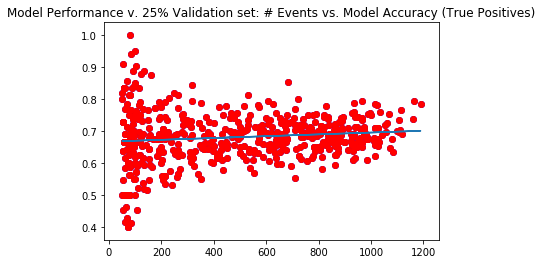

In [65]:
from scipy import stats

#fig, hist = plt.subplots(1, 2, sharex = True)
x = perf_results['num_events-R']
y = perf_results['model_score-R']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.plot(x,y,'ro', x, line)
plt.scatter(x,y, color = 'b')
#plt.hist(RHP_90d['counts'], bins, alpha = 0.5, label = 'RHP')
#plt.hist(LHP_90d['counts'], bins, alpha = 0.5, label = 'LHP')
#plt.legend(loc='upper right')
plt.title('Model Performance v. 25% Validation set: # Events vs. Model Accuracy (True Positives)')
plt.show()

In [66]:
print("slope, intercept, r_value, p_value, std_err:")
print(slope, intercept, r_value, p_value, std_err)

slope, intercept, r_value, p_value, std_err:
2.8389777562654084e-05 0.6670271790792393 0.11888097365628503 0.005542863964800245 1.019436638097904e-05


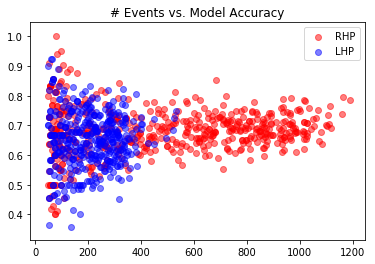

In [67]:
#fig, hist = plt.subplots(1, 2, sharex = True)
xr = perf_results['num_events-R']
yr = perf_results['model_score-R']
plt.scatter(xr,yr, color = 'red', alpha = 0.5, label = 'RHP')

xl = perf_results['num_events-L']
yl = perf_results['model_score-L']
plt.scatter(xl,yl, color = 'blue', alpha = 0.5, label = 'LHP')
plt.legend(loc='upper right')
plt.title('# Events vs. Model Accuracy')
plt.show()


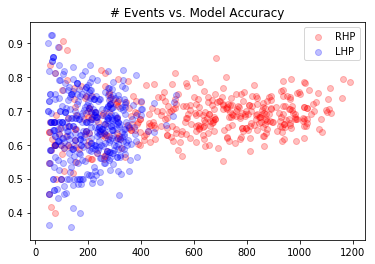

In [68]:
#fig, hist = plt.subplots(1, 2, sharex = True)
xr = filtered['num_events-R']
yr = filtered['model_score-R']
plt.scatter(xr,yr, color = 'red', alpha = 0.25, label = 'RHP')

xl = filtered['num_events-L']
yl = filtered['model_score-L']
plt.scatter(xl,yl, color = 'blue', alpha = 0.25, label = 'LHP')
plt.legend(loc='upper right')
plt.title('# Events vs. Model Accuracy')
plt.show()


#### Comments
- Model performance decreases with greater #s
- Could suggest we should process results more frequently (say, weekly), OR that we should consider other models

#### To Do
- Clean up append of record count and model performance so we get RH and LH results, separately (currently overwriting w/LH data only)
- Look at histograms of results above, to observe distribution of model performance results